In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

### Load Data

In [2]:
train_raw=pd.read_csv("train.csv", index_col="Id")
print(train_raw.shape)
test_raw=pd.read_csv("test.csv", index_col="Id")
test_raw["SalePrice"] = 0
print(test_raw.shape)

(1460, 80)
(1459, 80)


In [3]:
df = pd.concat([train_raw,test_raw], axis=0, sort=False)
print(df.shape)

(2919, 80)


In [4]:
len(train_raw.columns)

80

In [ ]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Numerical', 'Ordinal', 'Nomical'
sizes = [27.5, 19, 53.5]
explode = (0.1,0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### EDA

In [ ]:
### Overall
train_raw.hist(bins = 30, figsize = (20,20))

In [ ]:
def numeric_col(data):
    coln = data.describe().columns
    numeric_features=[]
    for col in coln :
        if len(data[col].value_counts()) >16 :
            numeric_features.append(col)
    return numeric_features

numeric_features = numeric_col(df)

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(train_raw[numeric_features], figsize=(12,8))

In [ ]:
#box plot overallqual/saleprice
var = "OverallQual"
data = pd.concat([train_raw['SalePrice'], train_raw[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

#sactter plot YearBuilt/saleprice
var =  "YearBuilt" 
data = pd.concat([train_raw['SalePrice'], train_raw[var]], axis=1)
data.plot.scatter(x=var, y = 'SalePrice', ylim=(0,800000),figsize=(8, 6))


In [ ]:
## Check Skewness of target value 
sns.distplot(train_raw['SalePrice'])
fig = plt.figure()
res = stats.probplot(train_raw['SalePrice'], plot=plt);

In [ ]:
x =np.log1p(train_raw["SalePrice"])

In [ ]:
#transformed histogram and normal probability plot
sns.distplot(x, fit=norm);
fig = plt.figure()
res = stats.probplot(x, plot=plt)

### Missingness  Treatment

In [ ]:
#missing value counter
def na_counter(data):
    coln = list(data.columns)
    df_na ={}
    for col in coln:
        if data[col].isnull().any()==True:
            mvalue = data[col].isnull().sum()
            mpercent = data[col].isnull().sum()/len(data)
            df_na[col]=[mvalue, mpercent]
    df_Na =pd.DataFrame(df_na).T
    df_Na.columns = ['NA',"PERCENT"]
    return df_Na

In [ ]:
na_df = na_counter(df)

In [ ]:
na_df["PERCENT"].sort_values(ascending = False).plot.bar()

### Imputation 

#### 1. Simply "None"

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
       
#### 2. Information from other columns

MSZoning: Identifies the general zoning classification of the sale.

       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

In [ ]:
# Zoning - Neighborhood correlate
test.loc[test["MSZoning"].isnull(),['Neighborhood']]
# check MSZoning values
test.loc[test['Neighborhood']=="IDOTRR", "MSZoning"].value_counts()
# Most of IDOTRR -> RM zone
train_test["MSZoning"] = train_test["MSZoning"].fillna("RM")


#LotFrontage based on Neighborhood feature
train_test["LotFrontage"] = train_test["LotFrontage"].fillna(df.groupby("Neighborhood")["LotFrontage"].transform("mean"))

### Feature Engineering 

In [ ]:
def impute_null_fields(df):
    
    print("\n\n*****\nImputing Null values....")
    print("Null counts before imputing:")
    print(na_counter(df))
    

    """ ?? """
    df["MSZoning"] = df["MSZoning"].fillna("RM")
    df["LotFrontage"] = df["LotFrontage"].fillna(df.groupby("Neighborhood")["LotFrontage"].transform("mean"))

    df["MasVnrType"] = df["MasVnrType"].fillna("None") 
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0.0) 
    df["BsmtQual"] = df["BsmtQual"].fillna("NoBsmt")
    df["BsmtCond"] = df["BsmtCond"].fillna("NoBsmt")
    df["BsmtExposure"] = df["BsmtExposure"].fillna("NoBsmt")
    df["BsmtFinType1"] = df["BsmtFinType1"].fillna("NoBsmt")
    df["BsmtFinType2"] = df["BsmtFinType2"].fillna("NoBsmt")
    df['Exterior1st'] = df['Exterior1st'].fillna("None") 
    df['Exterior2nd'] = df['Exterior2nd'].fillna("None")
    df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0) 
    df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0) 
    df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0) 
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0) 
    

    """ Only one row missing the value, impute with "SBrkr" which is the most used """
    df.Electrical = df.Electrical.fillna("SBrkr")

    """ Impute with equavelant of overall house quality : Average, equivalent "TA" """
    df.KitchenQual = df.KitchenQual.fillna("None")

    df.FireplaceQu = df.FireplaceQu.fillna("None")
    
    """ First change Garage Type for row with Null area and then change Garage Area """
    df.loc[df.GarageArea.isnull(), "GarageType"] = np.nan
    df.loc[df.GarageArea.isnull(), "GarageArea"] = 0
    
        

    """ For one record with Garage Area 360 and with missing Garage values, set to average values based on Overall Quality """
    df.loc[(df.GarageArea==360) & df.GarageFinish.isnull(), "GarageFinish"] = "Unf"
    df.loc[(df.GarageArea==360) & df.GarageQual.isnull(), "GarageQual"] = "TA"
    df.loc[(df.GarageArea==360) & df.GarageCond.isnull(), "GarageCond"] = "TA"
    """ Setting the Garage built to "Year Remodelled" """
    df.loc[(df.GarageArea==360) & df.GarageYrBlt.isnull(), "GarageYrBlt"] = df.YearRemodAdd


    
    """ Set rest of the missing Garage valies to None and GarageCars to zero"""
    df.GarageFinish = df.GarageFinish.fillna("None")
    df.GarageQual = df.GarageQual.fillna("None")
    df.GarageCond = df.GarageCond.fillna("None")
    df.GarageType = df.GarageType.fillna("None")

    df.GarageCars = df.GarageCars.fillna(0)


    """ Is it correct to fill with Zero for Year built as the scale will change compared to most values in 1900""" 
    df.loc[df.GarageYrBlt.isnull(), "GarageYrBlt"] = df.YearRemodAdd


    """ Impiute with Typ as mentioned in documentation. There does not seem to be clear relation with
        Overall quality fields
    """
    df.loc[df.Functional.isnull(), "Functional"] = "Typ"


    """Basement Fullbath and Halfbath NA values are related to  houses without basements. Soe set them to 0 """
    df.BsmtFullBath = df.BsmtFullBath.fillna(0)
    df.BsmtHalfBath = df.BsmtHalfBath.fillna(0)
    
    
    """ Other """
    df['SaleType'] = df['SaleType'].fillna("Oth")
    df['GarageQual'] = df['GarageQual'].fillna("None")
    
    df["Alley"] = df["Alley"].fillna("None")
    df["Fence"] = df["Fence"].fillna("None")
    

    print("\n\n\nNull counts after imputing:")
    print(na_counter(df))

    return df

In [ ]:
def correct_data(df):
    
    print("\n\n*****\nCorrecting incorrect data values...")

    """Seems the year is 2207 is a typo, setting to the year remodeled"""
    df.loc[df.GarageYrBlt==2207, "GarageYrBlt"] = 2007
    return df

In [ ]:

def transform_ordinal(df):
    typical_graded_cols = ["HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "ExterQual",
                          "ExterCond", "BsmtQual", "BsmtCond"]
    typical_grade_map = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

    for i in typical_graded_cols:
        df[i].replace(typical_grade_map, inplace=True)
    
    df['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)
    df['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)
    df["BsmtExposure"].replace({"NoBsmt": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}, inplace=True)
    df["GarageType"].replace({"attachd" : 2, "Detchd": 1,"BuiltIn" :2, "2Types":0, "CarPort":0,'Basment':0}, inplace=True)
    
    df["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}, inplace =True)
    df["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0}, inplace =True)
    
    bsmt_fin_dict = {"NoBsmt": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    df["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
    df["BsmtFinType2"].map(bsmt_fin_dict).astype(int)
    
    df["Fence"].replace({"None": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

    return df

In [ ]:
def feature_transformation(df):
    
    print("\n\n*****\n Transforming features ...")


    """ Changing Columns to Binary where majority values are one specific value and rest all had 
    similar pattern against SalePrice
    """
    df["Electrical"] = np.where(df["Electrical"].str.contains("SBrkr"),1, 0).astype(int)
    df["Heating"] = np.where(df["Heating"].str.contains("GasA"), 1, 0).astype(int)
    df["RoofMatl"] = np.where(df["RoofMatl"].str.contains("CompShg|WdShngl", regex=True), 1,0).astype(int)
    df["MiscFeature"] = np.where(df["MiscFeature"].str.contains("Shed"),1, 0).astype(int)
    df["Condition2"] = np.where(df["Condition2"].str.contains("Norm"),1, 0).astype(int)
    

    df["PoolArea"]=np.where(df["PoolArea"]>1,1,0)
    df["WoodDeckSF"]=np.where(df["WoodDeckSF"]>1,1,0)
    df["OpenPorchSF"]=np.where(df["OpenPorchSF"]>1,1,0)
    df["EnclosedPorch"]=np.where(df["EnclosedPorch"]>1,1,0)
    df["3SsnPorch"]=np.where(df["3SsnPorch"]>1,1,0)
    df["ScreenPorch"]=np.where(df["ScreenPorch"]>1,1,0)
    df["LowQualFinSF"]=np.where(df["LowQualFinSF"]>1,0,1)


    return df

In [ ]:
def data_transformation(df):
    
    print("\n\n*****\n Transforming data values ...")

    df.loc[(df.OverallCond==2) &( df.SalePrice>300000), "OverallCond"] = 5
    df["LotFrontage"][df["LotFrontage"]>150]= 174
    df.loc[(df.LotArea>100000), "LotArea"] = 70000
    df.loc[(df.BsmtFinSF1>=3000),"BsmtFinSF1"]=4000
    
    # train_raw["SalePrice"].groupby(train_raw["Neighborhood"]).mean().sort_values()


    
    return df

In [ ]:
def feature_generation(df):
    
    """ remodelling year""" 
    df["Remod"] = (df["YearRemodAdd"] != df["YearBuilt"]) * 1
    
    """ Brand New House """
    df["BNewHouse"] = (df["YearBuilt"] == df["YrSold"]) * 1
    
    """"Age of building """ 
    df["Age"] = 2019 - df["YearBuilt"]
   
    """" Total Area"""
    area = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    df["TotalArea"] = df[area].sum(axis=1)
    
    """ Consolidate columns and drop related columns"""
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df["TotalFullBaths"] = df["BsmtFullBath"]+df["FullBath"]
    df = df.drop(["BsmtFullBath","FullBath", "BsmtHalfBath", "HalfBath" ], axis=1)
    
    """ Dropping 1st and 2nd Floor SFT as they are collinear with GrLivArea"""
    df = df.drop([ '1stFlrSF', '2ndFlrSF',], axis=1)
    
    """ Combine Porchs"""
    df["TotalPorch"] = df["OpenPorchSF"]+df["EnclosedPorch"]+df["3SsnPorch"]+df["ScreenPorch"]
    df = df.drop([ "OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"], axis=1)

    
    return df

In [ ]:
def drop_columns(df):
    
    print("\n\n*****\nDropping selective columns...")
    columns_to_drop = ["Street","Utilities","PoolQC", "MiscVal"]

    columns_to_drop = columns_to_drop + ["BsmtFinSF2"]

    
    print("\n\n*****\nNo of columns before dropping : ", len(df.columns))
    print("No of columns to drop : ", len(columns_to_drop))
    
    df.drop(columns_to_drop, axis=1, inplace=True)
    print("No of columns after dropping : ", len(df.columns))

    return df

In [ ]:
df = impute_null_fields(df)
df = correct_data(df)
df = transform_ordinal(df)
df = feature_transformation(df)
df = data_transformation(df)
df = feature_generation(df)
df = drop_columns(df)

In [ ]:
df.isnull().any().sum()

In [ ]:
df.to_csv("train_test.csv")

In [5]:
df =pd.read_csv("train_test.csv", index_col="Id")

In [ ]:
df.head()

#### Multicollinearity

In [7]:
numeric_features  = df.describe().columns

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 <a list of 47 Text xticklabel objects>)

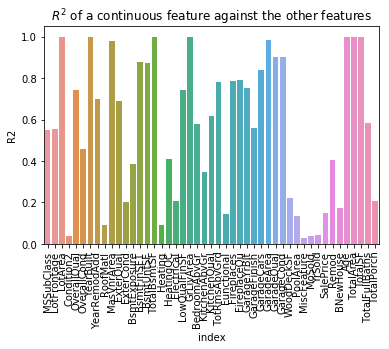

In [8]:
from sklearn import linear_model
scores = {}
lm = linear_model.LinearRegression()
from sklearn.metrics import r2_score
for feature_name in numeric_features:
    df_numeric = df[numeric_features].copy()
    feature = df[feature_name].copy()
    df_numeric.drop(feature_name, axis=1, inplace=True)
    lm.fit(df_numeric, feature)
    scores[feature_name] = lm.score(df_numeric, feature)  
    
sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.title('$R^2$ of a continuous feature against the other features')
plt.xticks(rotation=90)

In [ ]:
df = df.drop(['TotalSF'], axis=1)

#### Skewness 

In [9]:
# Check the skew of all numerical features
df_log = df.copy()
from scipy import stats
from scipy.stats import norm, skew 

def numeric_col(data):
    coln = data.describe().columns
    numeric_features=[]
    for col in coln :
        if len(data[col].value_counts()) >16 :
            numeric_features.append(col)
    return numeric_features

numeric_features = numeric_col(df)

skewed_feats =df_log[numeric_features].apply(lambda x: skew(x.dropna().astype(float))).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness)
skewness = skewness[abs(skewness)>0.75]
df_log[skewness.index] = np.log1p(df_log[skewness.index])

# Additional processing: scale the data.   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_log[numeric_features])

scaled = scaler.transform(df_log[numeric_features])
for i, col in enumerate(numeric_features):
    df_log[col] = scaled[:, i]



Skew in numerical features: 

                  Skew
LotArea       4.459077
TotalArea     3.600242
MasVnrArea    2.613592
TotalSF       1.511479
GrLivArea     1.269358
TotalBsmtSF   1.156894
BsmtFinSF1    1.120355
SalePrice     1.098792
BsmtUnfSF     0.919339
LotFrontage   0.676851
Age           0.599806
GarageArea    0.239257
YearRemodAdd -0.451020
YearBuilt    -0.599806
GarageYrBlt  -0.620746


In [ ]:
skewness.hist()

In [10]:
#boxcox
df_bc =df.copy()
skewness = skewness[abs(skewness) > 0.75]
from scipy.special import boxcox1p

skewed_feats =df_bc[numeric_features].apply(lambda x: skew(x.dropna().astype(float))).sort_values(ascending=False)
df_bc[skewness.index] = boxcox1p(df_bc[skewness.index], 0.15)

skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness  

scaler = StandardScaler()
scaler.fit(df_bc[numeric_features])

scaled = scaler.transform(df_bc[numeric_features])
for i, col in enumerate(numeric_features):
    df_bc[col] = scaled[:, i]
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
LotArea,4.459077
TotalArea,3.600242
MasVnrArea,2.613592
TotalSF,1.511479
GrLivArea,1.269358
TotalBsmtSF,1.156894
BsmtFinSF1,1.120355
SalePrice,1.098792
BsmtUnfSF,0.919339
LotFrontage,0.676851


In [ ]:
df_log.isnull().any().sum()

In [ ]:
def value_counts(data):        
    for col in (data.columns):
        if len(data[col].value_counts()) <26 :
            print(data[col].value_counts())


### Dummy Variables 

In [11]:
df_dum = df_log.copy()
df_bc_dum = df_bc.copy()

In [12]:
def make_dummies(df):
    cat_col=[]
    coln = df.columns
    for col in coln :
        if len(df[col].value_counts()) <26 :
            cat_col.append(col)
    for feature in cat_col:
        new_dummy = pd.get_dummies(df[feature], prefix=feature,drop_first=False)
        df = pd.concat([df.drop(feature, axis=1), new_dummy], axis=1)

    return df

In [13]:
df_dum =make_dummies(df_dum)

In [14]:
df_dum = df_dum.drop(['MSSubClass_0', 'MSZoning_C (all)',
                     "Alley_Pave", 'LotShape_IR3',
                    'LandContour_Low','LotConfig_FR3', 'LandSlope_Sev', 'Neighborhood_Blueste', 
                    'Condition1_RRNe',"Condition2_0",
                    'BldgType_2fmCon', 'HouseStyle_2.5Fin', 'OverallQual_1', 'OverallCond_1',"RoofStyle_Shed",
                    "RoofMatl_0","Exterior1st_None","Exterior2nd_None","Exterior2nd_Other","MasVnrType_BrkCmn",
                    "ExterQual_2","ExterCond_1","Foundation_Wood","BsmtQual_2","BsmtCond_1","BsmtExposure_0",
                    "BsmtFinType2_GLQ","Heating_0","HeatingQC_1","Electrical_0",
                    "LowQualFinSF_0","BedroomAbvGr_8","KitchenAbvGr_3","KitchenQual_0","TotRmsAbvGrd_2","TotRmsAbvGrd_14",
                    "TotRmsAbvGrd_13","TotRmsAbvGrd_15","Functional_1","Fireplaces_4","FireplaceQu_5","GarageType_0",
                    "GarageFinish_0","GarageCars_5.0","GarageQual_5","GarageCond_5","PavedDrive_P","WoodDeckSF_0",
                    "PoolArea_0","Fence_MnWw","YrSold_2010","SaleType_Con","SaleCondition_AdjLand","Remod_0","BNewHouse_1",
                    "TotalFullBaths_0.0","TotalPorch_3"], axis=1)

In [15]:
df_bc_dum =make_dummies(df_bc_dum)

In [16]:
df_bc_dum = df_bc_dum.drop(['MSSubClass_0', 'MSZoning_C (all)',
                     "Alley_Pave", 'LotShape_IR3',
                    'LandContour_Low','LotConfig_FR3', 'LandSlope_Sev', 'Neighborhood_Blueste', 
                    'Condition1_RRNe',"Condition2_0",
                    'BldgType_2fmCon', 'HouseStyle_2.5Fin', 'OverallQual_1', 'OverallCond_1',"RoofStyle_Shed",
                    "RoofMatl_0","Exterior1st_None","Exterior2nd_None","Exterior2nd_Other","MasVnrType_BrkCmn",
                    "ExterQual_2","ExterCond_1","Foundation_Wood","BsmtQual_2","BsmtCond_1","BsmtExposure_0",
                    "BsmtFinType2_GLQ","Heating_0","HeatingQC_1","Electrical_0",
                    "LowQualFinSF_0","BedroomAbvGr_8","KitchenAbvGr_3","KitchenQual_0","TotRmsAbvGrd_2","TotRmsAbvGrd_14",
                    "TotRmsAbvGrd_13","TotRmsAbvGrd_15","Functional_1","Fireplaces_4","FireplaceQu_5","GarageType_0",
                    "GarageFinish_0","GarageCars_5.0","GarageQual_5","GarageCond_5","PavedDrive_P","WoodDeckSF_0",
                    "PoolArea_0","Fence_MnWw","YrSold_2010","SaleType_Con","SaleCondition_AdjLand","Remod_0","BNewHouse_1",
                    "TotalFullBaths_0.0","TotalPorch_3"], axis=1)

In [17]:
df_dum.shape

(2919, 280)

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(df_bc, figsize=(12, 8))

### Model validation

In [18]:
from sklearn.model_selection import train_test_split

## Split data in 2 
train, test = np.split(df_dum,[1460])
test = test.drop("SalePrice", axis=1)

print(train.shape)
print(test.shape)

X = train.drop("SalePrice", axis=1)
y = np.log1p(train_raw["SalePrice"])
print("X and y:" ,X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
# train_X, test_X, train_Y, test_Y = train_test_split(train_data.iloc[:,:-1], train_data.iloc[:,-1:],test_size=0.2, random_state=99)



print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(1460, 280)
(1459, 279)
X and y: (1460, 279) (1460,)
(1168, 279)
(1168,)
(292, 279)
(292,)


In [19]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

C:\Users\Soo\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [21]:
#define a rmsle evaluation function

def rmsle(y, y_pred): 
    return np.sqrt(mean_squared_error(y, y_pred))

- linear_regression

In [ ]:
lm = linear_model.LinearRegression()
ridge = linear_model.Ridge
lasso = linear_model.Lasso
ENet = linear_model.ElasticNet(alpha = 1, l1_ratio = 0.5)

In [ ]:
lm.fit(X, y)
lm_train_pred = lm.predict(X)
lm_test_pred = np.expm1(lm.predict(test.values))
print(rmsle(y, lm_train_pred))

In [ ]:
lm.fit(X_train, y_train)
print("train: {:.2f}".format(lm.score(X_train, y_train)))
print("test: {:.2f}".format(lm.score(X_test, y_test)))

In [ ]:
score = rmsle_cv(lm)
print("\nlm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

- Ridge

In [ ]:
ridge05 = ridge(alpha=10).fit(X_train, y_train)
ridge05.fit(X, y)
ridge05_train_pred = ridge05.predict(X)
ridge05_test_pred = np.expm1(ridge05.predict(test))
print(rmsle(y, ridge05_train_pred))

In [ ]:
score = rmsle_cv(ridge05)
print("train: {:.2f}".format(ridge05.score(X_train, y_train)))
print("test: {:.2f}".format(ridge05.score(X_test, y_test)))
print("\nridge rmse score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

- Lasso

In [22]:
lasso01 = Lasso(alpha=0.0003).fit(X, y)
lasso01_train_pred = lasso01.predict(X)
lasso01_test_pred = np.expm1(lasso01.predict(test))
print(rmsle(y, lasso01_train_pred))

0.10629101366610633


In [34]:
lasso = Lasso(alpha=0.0003,max_iter=50000).fit(X_train, y_train)
print("train: {:.2f}".format(lasso.score(X_train, y_train)))
print("test: {:.2f}".format(lasso.score(X_test, y_test)))
print("feature size: {}".format(np.sum(lasso.coef_ != 0)))
score = rmsle_cv(lasso)
print("\nlasso rmse score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

train: 0.93
test: 0.92
feature size: 153

lasso rmse score: 0.1248 (0.0204)



- ENET

In [24]:
EN = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0003, l1_ratio=.9, random_state=3))
EN.fit(X,y)
ENet_train_pred = EN.predict(X)
ENet_pred = np.expm1(EN.predict(test))
print(rmsle(y, ENet_train_pred))
EN.fit(X_train,y_train)
print("train: {:.2f}".format(EN.score(X_train, y_train)))
print("test: {:.2f}".format(EN.score(X_test, y_test)))
score = rmsle_cv(EN)
print("ElasticNet rmse score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

0.10564237805533491
train: 0.93
test: 0.92
ElasticNet rmse score: 0.1248 (0.0204)



- DT

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree = DecisionTreeRegressor(max_depth=9, random_state=0)
tree.fit(X_train, y_train)

print("train accuracy: {:.3f}".format(tree.score(X_train, y_train)))
print("test accuracy: {:.3f}".format(tree.score(X_test, y_test)))
score = rmsle_cv(tree)
print("\ntree rmsescore: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
print("feature importance:\n{}".format(tree.feature_importances_))
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("importance")
    plt.ylabel("features")
    plt.ylim(-1, n_features)

plot_feature_importances(tree)

- Random Forest

In [ ]:
forest = RandomForestRegressor(n_estimators=3000, random_state=0)
forest.fit(X_train, y_train)

print("train acc: {:.3f}".format(forest.score(X_train, y_train)))
print("test acc: {:.3f}".format(forest.score(X_test, y_test)))
score = rmsle_cv(forest)
print("\nforest rmsescore: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

- Gboost

In [ ]:
# GBoost = GradientBoostingRegressor(random_state =0)
# GBoost.fit(X_train, y_train)

# print("GBoost acc: {:.3f}".format(GBoost.score(X_train, y_train)))
# print("GBoost acc: {:.3f}".format(GBoost.score(X_test, y_test)))

In [35]:
GBoost = GradientBoostingRegressor(n_estimators=3500, learning_rate=0.05,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GBoost.fit(X_train, y_train)
print("GBoost train acc: {:.3f}".format(GBoost.score(X_train, y_train)))
print("GBoost test acc: {:.3f}".format(GBoost.score(X_test, y_test)))
score = rmsle_cv(GBoost)
print("GBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

GBoost acc: 0.976
GBoost acc: 0.922
GBoost score: 0.1206 (0.0184)



In [26]:
GBoost.fit(X,y)
GBoost_train_pred = GBoost.predict(X)
GBoost_pred = np.expm1(GBoost.predict(test))
print(rmsle(y, GBoost_train_pred))

0.07028050076737614


In [27]:
from xgboost import XGBRegressor
import xgboost as xgb

# model_xgb = xgb.XGBRegressor(random_state =0)
# score = rmsle_cv(model_xgb)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:

model_xgb_c = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=7500,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =8, nthread = -1)

score = rmsle_cv(model_xgb_c)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
model_xgb_c.fit(X_train, y_train)

print("xgb train: {:.3f}".format(model_xgb_c.score(X_train, y_train)))
print("xgb test: {:.3f}".format(model_xgb_c.score(X_test, y_test)))

In [ ]:
model_xgb_c.fit(X,y)
xgb_train_pred = model_xgb_c.predict(X)
xgb_pred = np.expm1(model_xgb_c.predict(test))
print(rmsle(y, xgb_train_pred))

In [ ]:
import lightgbm as lgb

In [ ]:
# model_lgb = lgb.LGBMRegressor(objective='regression')
# score = rmsle_cv(model_lgb)
# print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [ ]:
model_lgb_c = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
score = rmsle_cv(model_lgb_c)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))
model_lgb_c.fit(X, y)
lgb_train_pred = model_lgb_c.predict(X)
lgb_pred = np.expm1(model_lgb_c.predict(test))
print(rmsle(y, lgb_train_pred))

- svm

In [ ]:
from sklearn.svm import SVR

In [ ]:

svr = SVR()
svr.fit(X_train, y_train)

print("train acc: {:.2f}".format(svr.score(X_train, y_train)))
print("test acc: {:.2f}".format(svr.score(X_test, y_test)))
# svr = SVR(C=1000)
# svr.fit(X_train, y_train)

# print("train acc: {:.2f}".format(svr.score(X_train, y_train)))
# print("test acc: {:.2f}".format(svr.score(X_test, y_test)))

In [ ]:
svr_01 = SVR(C=1, cache_size=200, coef0=0, degree=3, epsilon=0.0, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr_01.fit(X_train, y_train)

print("train acc: {:.2f}".format(svr_01.score(X_train, y_train)))
print("test acc: {:.2f}".format(svr_01.score(X_test, y_test)))
score = rmsle_cv(svr_01)
print("svc score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [ ]:
svr_01.fit(X, y)
svr_01_train_pred = svr_01.predict(X)
svr_01_test_pred = np.expm1(svr_01.predict(test))
print(rmsle(y, svr_01_train_pred))

In [ ]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

In [ ]:
ensemble = xgb_pred*0.25 + lgb_pred*0.5 + GBoost_pred*0.25 

In [ ]:
ensemble = ENet_pred*0.5 + GBoost_pred*0.5 

## Submission

In [ ]:
predictions = ensemble

print(predictions.shape)
predictions

In [ ]:
submission = pd.read_csv("sample_submission.csv")

In [ ]:
submission["SalePrice"] = predictions
submission.head()

In [ ]:
submission.to_csv("housemodel_ens_2gb2lgb.csv", index=False)

In [ ]:
################################################################################

# We take the log here because the error metric is between the log of the
# SalePrice and the log of the predicted price. That does mean we need to 
# exp() the prediction to get an actual sale price.
label_df = pd.DataFrame(index = train_df_munged.index, columns=["SalePrice"])
label_df["SalePrice"] = np.log(train_df["SalePrice"])

print("Training set size:", train_df_munged.shape)
print("Test set size:", test_df_munged.shape)

################################################################################

# XGBoost -- I did some "manual" cross-validation here but should really find
# these hyperparameters using CV. ;-)

import xgboost as xgb

regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train_df_munged)
y_test = label_df
print("XGBoost score on training set: ", rmse(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(test_df_munged)

################################################################################

from sklearn.linear_model import Lasso

# I found this best alpha through cross-validation.
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train_df_munged)
y_test = label_df
print("Lasso score on training set: ", rmse(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_lasso = regr.predict(test_df_munged)

################################################################################

# Blend the results of the two regressors and save the prediction to a CSV file.

y_pred = (y_pred_xgb + y_pred_lasso) / 2
y_pred = np.exp(y_pred)

pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('ens_EN_xgb.csv', header=True, index_label='Id')
